# Survival Analysis in Python

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

### Introduction

This notebook reviews two ways we have previously seen to represent a distribution, PMFs and CDFs, and introduces two new ways, survival functions and hazard functions.

All four representation are equivalent in the sense that if you are given any of them, you can compute the others.  So you might wonder why we need four ways to represent the same information.  There are two reasons:

1. Each representation is useful for computing different values and answering different questions.  In this notebook I'll show you what each representation is good for.

2. In some cases we can use a sample to compute a PMF, and use the PMF to compute the other representations.  In other cases it is easier to estimate the hazard function and use it to compute the others.

In this notebook I will demonstrate the first process, starting with the PMF.  In the next notebook we'll see the second process, starting with the hazard function.

### Setup

If you are running this notebook in Colab, the following cell installs the `empiricaldist` library, which provides objects that represent PMFs, CDFs, survival functions, and hazard functions.

If you are running in another environment, you will need to install it yourself.

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

If everything we need is installed, the following cell should run without error.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf, Cdf, Surv, Hazard

/home/downey/anaconda3/envs/SurvivalAnalysisPython/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The following is a function I use to decorate the axes of a figure.

In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## Light bulb lifetimes

As a first example, I'll use I'll use data from an experiment that measures the lifetimes of 50 light bulbs.

I downloaded the data from from [https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1], which includes this documentation:

```
Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: 
Theory and Experiment. Journal of Failure Analysis and Prevention. 
December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

Description:

An assembly of 50 new Philips (India) lamps with the 
rating 40 W, 220 V (AC) was taken and installed in the horizontal 
orientation and uniformly distributed over a lab area 11 m by 7 m. 

The assembly was monitored at regular intervals of 12 h to
look for failures. The instants of recorded failures were
called t‘ and a total of 32 data points were obtained such
that even the last bulb failed. 

Variables:

i - observation number
h - time in hours since experiment start
f - number of failed lamps at particular time h
K - number of surviving lamps  at particular time h
```

Because of the design of this experiment, we can consider the data to be a representative sample from the distribution of lifetimes, at least for light bulbs that are lit continuously.

The following cell downloads the data from a repository on GitHub (thanks to Evgeny Pogrebnyak for making it available).  

If that fails, you should be able to [get it from my repository](https://github.com/AllenDowney/SurvivalAnalysisPython/raw/master/lamps.csv).

In [4]:
# Load the data file

import os

datafile = 'lamps.csv'
if not os.path.exists(datafile):
    !wget https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv

We can load the data from the CSV file.

In [5]:
df = pd.read_csv('lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


This dataset is complete in the sense that the experiment ran until all light bulbs failed, so the lifetime for every bulb is known.

## PMF

In that case we can make a `Pmf` object that represents the distribution of lifetimes.  The result is a series that contains the lifetimes (column `h`) as quantities and the normalized number of failures (column `f`) as probabilities.

In [6]:
pmf = Pmf(df['f'].values, index=df['h'])
pmf.normalize()
pmf.head()

h
0      0.00
840    0.04
852    0.02
936    0.02
960    0.02
dtype: float64

For a given quantity, `q`, the PMF computes the fraction of the population at that quantity, exactly.

For example, we can compute the fraction of light bulbs that lasted 840 hours:

In [7]:
pmf(840)

0.04

Because of the way the experiment was conducted, all quantities are multiples of 12 hours.  If we ask about a quantity that is not a multiple of 12, the result is 0.

In [8]:
pmf(841)

0

Here's what the PMF looks like.

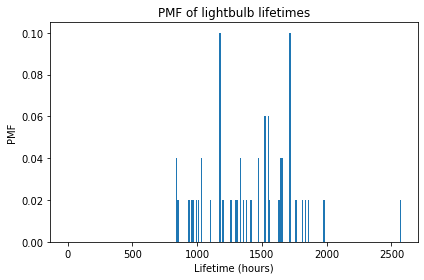

In [9]:
pmf.bar(width=10)
decorate(xlabel='Lifetime (hours)', 
         ylabel='PMF', 
         title='PMF of lightbulb lifetimes')

This way of visualizing the data can be useful for validation, and it gives a sense of the location and spread of the data.  But it does not make the shape of the distrbution clear.  For that, the CDF is better.

## CDF

The CDF is the cumulative sum of the PMF.  We could compute it ourselves like this:

In [10]:
cdf = pmf.cumsum()
cdf.head()

h
0      0.00
840    0.04
852    0.06
936    0.08
960    0.10
dtype: float64

In that case the result is a Pandas Series.

We can also use `Pmf.make_cdf`, which does the same calculation, but the result is a `Cdf` object.

In [11]:
cdf = pmf.make_cdf()
cdf.head()

h
0      0.00
840    0.04
852    0.06
936    0.08
960    0.10
dtype: float64

For a given quantity, `q`, the CDF computes the fraction of the population less than or equal to `q`.

For example, here is the fraction of light bulbs that expired at or before 840 hours:

In [12]:
cdf(840)

array(0.04)

And the fraction that expired at or before 852 hours.

In [13]:
cdf(852)

array(0.06)

For any quantity `q`, the CDF computes the corresponding cumulative probability, `p`.

But it also works the other way.  For a given probability, `p`, you can use the inverse CDF to compute the corresponding quantity, `q`.

In [14]:
cdf.inverse(0.06)

array(852.)

With `p=0.5`, the result is the 50th percentile, or median:

In [15]:
cdf.inverse(0.5)

array(1416.)

We can also use `inverse` to compute the quartiles, which are the quantities at the 25th, 50th, and 75th percentiles:

In [16]:
cdf.inverse([0.25, 0.5, 0.75])

array([1176., 1416., 1656.])

In my opinion, the CDF is often the best way to visualize the distribution of a sample.

Here it is, plotted as a step function.

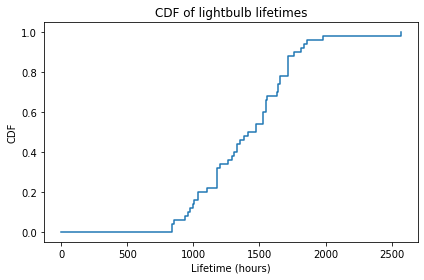

In [17]:
cdf.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='CDF', 
         title='CDF of lightbulb lifetimes')

In [18]:
cdf.inverse([0.05, 0.95])

array([ 852., 1860.])

Between 800 and 1800 hours, the CDF is roughly a straight line, which suggests that the distribution is uniform in this range.

## Survival function

The survival function is the complement of the CDF; that is, for a given quantity, `q`:

* The CDF is the fraction of the population less than or equal to `q`.

* The survival function is the fraction (strictly) greater than `q`.

Again, we can compute the survival function using Pandas Series operators:

In [19]:
surv = 1-cdf
surv.head()

h
0      1.00
840    0.96
852    0.94
936    0.92
960    0.90
dtype: float64

We can also use `Cdf.make_surv`, which does the same calculation and returns a `Surv` object:

In [20]:
surv = cdf.make_surv()
surv.head()

h
0      1.00
840    0.96
852    0.94
936    0.92
960    0.90
dtype: float64

In [21]:
surv[0]

1.0

We can use `surv` to compute the fraction of lightbulbs that live longer than 936 hours:

In [22]:
surv(936)

array(0.92)

And confirm that the CDF and survival functions add up to 1 (at least within floating-point error).

In [23]:
cdf(936) + surv(936)

1.0

If we plot the survival function along with the CDF, we can see that they complement each other.

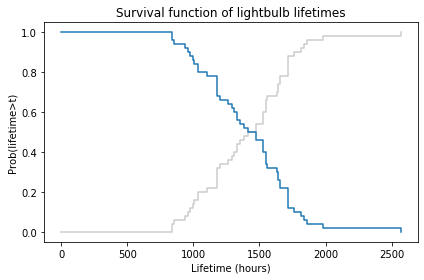

In [24]:
cdf.step(color='gray', alpha=0.4)
surv.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

Most often, a quantity in a survival function represents a lifetime of some kind.  In some cases it is literally the time until a death; in other cases "lifetime" is more metaphorical.  It might represent the time until a device breaks, or the time until a particular event occurs, even if the event has nothing to do with life or death.

For example, [in one project I worked on](http://allendowney.blogspot.com/2015/07/will-millennials-ever-get-married.html), I used survival curves to represent people's age at first marriage.

It might not be obvious why the survival function is useful.  Given the CDF and a little arithmetic, we can answer all of the same questions.

There are two reasons:

* In some domains it is more natural, or at least conventional, to represent distributions in terms of survival rates.

* The survival function is a step on the way to the hazard function, which we'll get to now.

## Hazard function

For a given time `q`, the hazard function computes the "hazard rate" at `q`.  Using the vocabulary of the light bulb example, the hazard rate is the fraction of light bulbs that survive until `q` and then fail at `q`.

We can compute the hazard rate by computing these quantities:

* `pmf(q)` is the fraction of light bulbs that fail at `q`.

* `surv(q)` is the fraction of light bulbs that live longer than `q`.

* The sum, `pmf(q) + surv(q)` is the fraction that survive until `q`. 

So the hazard rate is the ratio of `pmf(q)` to the sum `pmf(q) + surv(q)`.

We can compute it like this:

In [25]:
haz = pmf / (pmf + surv)
haz.head()

h
0      0.000000
840    0.040000
852    0.020833
936    0.021277
960    0.021739
dtype: float64

Or we can use `Surv.make_hazard`, which does the same thing and returns a `Hazard` object:

In [26]:
haz = surv.make_hazard()
haz.head()

h
0      0.000000
840    0.040000
852    0.020833
936    0.021277
960    0.021739
dtype: float64

Here's what the hazard function looks like:

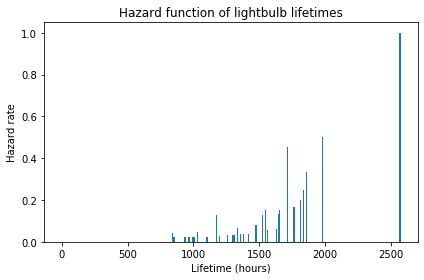

In [27]:
haz.bar(width=10)
decorate(xlabel='Lifetime (hours)', 
         ylabel='Hazard rate', 
         title='Hazard function of lightbulb lifetimes')

This way of visualizing the hazard function doesn't work very well; in the next section we'll see if we can do better.

## Visualizing the hazard function

With this kind of data, plotting the hazard function does not provide a clear picture of what's happening.  There are two problems:

1) The plot shows spikes at the locations of the data, but it is hard to see the shape of the curve.

2) The large values on the right are unreliable because they are based on a small number of values.

To explain the second point, let's look at the last few rows of the failure column, `f`:

In [28]:
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


We can see that one bulb failed at each of 1812, 1836, 1860, 1980, and 2568 hours.

So the last value of the hazard function is based on only one bulb, the second-to-last point is based on 2 bulbs, and so on.

To get a better sense of the shape of the curve, we can plot the cumulative hazard function, like this:

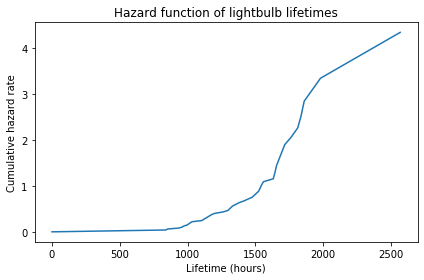

In [29]:
haz.cumsum().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Cumulative hazard rate', 
         title='Hazard function of lightbulb lifetimes')

The slope of the cumulative hazard function is proportional to the hazard rate, so we can use this curve to see when the hazard rate is low or high, and when it is increasing or decreasing.

Between 0 and 1000 hours, the slope is low, so the hazard rate is low.

Between 1000 and 2000 hours, the slope and hazard rate are increasing.

But notice that the vertical scale goes to 4.  You might wonder that that means; the answer is "not much".

The values of the hazard function are rates, that is, percentages of light bulbs that expire at each point in time.  When you add up these rates, the result does not have a clear interpretation.  

When you look at a cumulative hazard function, you should pay attention to the slope of the curve and ignore the values.

## Resampling

In the previous section, I suggested that we have to be careful not to overinterpret the right side of the hazard function, because it is based on a small number of data points.

To see how precise the estimated hazard function is, we can use resampling.

First I will use the Pmf of lifetimes to make a kernel density estimate (KDE) of the distribution.

In [30]:
from scipy.stats import gaussian_kde
    
kde = gaussian_kde(pmf.qs, weights=pmf.ps)

We can use the KDE to draw a new sample of lifetimes, with the same size as the original data set, and plot the survival curve for each sample.

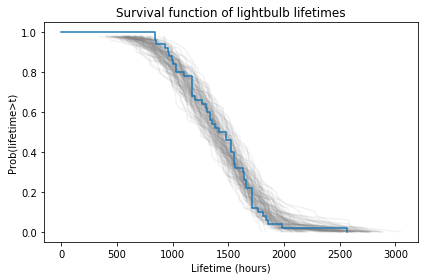

In [31]:
size = df['f'].sum()

for i in range(100):
    sample = kde.resample(size).flatten()
    sf = Surv.from_seq(sample)
    sf.plot(color='gray', alpha=0.1)
    
surv.step()
decorate(xlabel='Lifetime (hours)', 
         ylabel='Prob(lifetime>t)', 
         title='Survival function of lightbulb lifetimes')

By plotting the resampled survival curves on top of each other, we can get a sense of how much the results vary due to random sampling.

In this case the sample size is small, so the differences between resampled survival curves are substantial.

We can do the same thing with the hazard function:

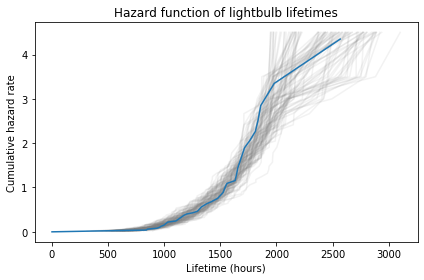

In [32]:
for i in range(100):
    sample = kde.resample(size).flatten()
    hf = Hazard.from_seq(sample)
    hf.cumsum().plot(color='gray', alpha=0.1)

haz.cumsum().plot()

decorate(xlabel='Lifetime (hours)', 
         ylabel='Cumulative hazard rate', 
         title='Hazard function of lightbulb lifetimes')

This plot gives us a sense of which parts of the cumulative hazard function are reliable and which are not.

Below 2000 hours, all of the resampled curves are similar; they increase with increasing slope.

After that, the variability of the curves is much wider, which means we don't have enough data to characterize this part of the hazard function.

## Summary

We have seen five ways to represent a distribution of lifetimes:

* Probability mass function (PMF), which maps from each value in the distribution to its probability.

* Cumulative distribution function (CDF), which maps from each value, `x`, to its cumulative probability, that is, the probability of being less than or equal to `x`.

* Survival function, which is the complement of the CDF; that is, the probability of exceeding `x`.

* Hazard function, which is the number of failures at `x` as a fraction of the number of cases that survive until `x`.

* Cumulative hazard function, which is useful for visualizing the shape of the hazard curve.

These representations of a distribution are equivalent in the sense that they all contain the same information.  Given any of them, we can compute any of the others.

In this notebook, we computed the `Pmf` directly from the data, then computed the `Cdf`, survival function, and hazard function, in that order.

But we can also go the other way, starting with the hazard function and working backwards.  To demonstrate, I'll use `haz` to compute the survival function, and confirm that the result is the same as `surv`, within floating point error.

In [33]:
surv2 = haz.make_surv()
max(abs(surv - surv2))

3.469446951953614e-18

And we can use `surv2` to compute the CDF:

In [34]:
cdf2 = surv2.make_cdf()
max(abs(cdf - cdf2))

2.220446049250313e-16

And `cdf2` to compute the PMF:

In [35]:
pmf2 = cdf2.make_pmf()
max(abs(pmf - pmf2))

9.367506770274758e-17

In the next notebook we will take advantage of this ability to deal with cases where we cannot compute the PMF directly from the data.